<H1>Prédiction des ventes chez Walmart </H1>


Le problème considéré ici est bâti à partir d'une compétion Kaggle, https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting
où il s'agissait de prévoir les ventes dans les différents départements des 45 magasins Walmart des Etats-Unis. 
Le problème a été simplifié ici en regroupant les ventes des différents départements pour ne s'intéresser qu'aux ventes globales des magasins, et en supprimant les données relatives aux campagnes publicitaires. 

Votre objectif sera donc de prédire les ventes des différents magasins, à partir d'un historique sur 3 années comprenant :

- fichier data.csv
    - 'Store':  numéro du magasin
    - 'Date' : date (semaine considérée)
    - 'Weekly_Sales' : ventes de la semaine (en \$)
    - 'Temperature' : température (en K)
    - 'Fuel_Price' : prix du carburant (en \$)
    - 'CPI' : [Consumer Price Index](https://www.bls.gov/cpi/)
    - 'Unemployment' : taux de chomage
    - 'IsHoliday' : période de vacances (Vrai/faux)

- fichier stores.csv
    - 'Store' : numéro du magasin
    - 'Type' : type de magasin
    - 'Size' : surface

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
SEED = 111

## 1 - Lecture des fichiers

Importer les fichiers `data.csv`  et `stores.csv`  dans des variables de même nom



In [3]:
data = pd.read_csv("data.csv")
stores = pd.read_csv("stores.csv")

> 1.1 Combien d'exemples contient `data`  ? Combien de magasins sont-ils répertoriés dans stores ?

In [4]:
data.head()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,False
1,1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,True
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,False
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,False
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,False


In [5]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


En affichant les premières lignes des 2 fichiers nous voyons que le fichier data.csv contient plusieurs occurrences de chaque magasin (plusieurs lignes pour 1 même magasin) alors que le fichier store.csv contient une occurrence de chaque magasin (une ligne = un magasin).

In [7]:
data["Store"].nunique() # nombre d'éléments uniques

45

In [10]:
stores.shape[0] # nombre de lignes = nombre de magasins

45

> 1.2 Quelle était la température la semaine du '2012-09-28' pour le magasin n°21 ? (Question non bloquante - si vous n'y arrivez pas, passez)

Une telle donnée se trouve dans le fichier data.csv et nous devons croiser deux conditions.

In [13]:
data[data["Date"]=='2012-09-28'][data["Store"]==21]

/Users/macbook/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
2998,21,2012-09-28,647097.65,80.38,3.666,222.616433,6.565,False


## 2 - Combinaison des données


On dispose donc à la fois d'une table `data` qui contient les ventes hebdomadaires et les conditions particulières pour les magasins, et d'une table `stores` qui contient des caractéristiques des magasins. 

>2.1 On souhaite alors combiner ces deux tables en une nouvelle table qui contiendra l'ensemble des données. Quelle fonction utiliser pour cela  : pd.merge, pd.concat, pd.append ? 

Nous utilisons merge (fonction pandas qui permet de combiner nos deux dataframe sur un critère de jointure choisi ici une colonne en commun) et nous combinons les deux fichiers sur la colonne Store :

> 2.2 Effectuez cette opération de regroupement, et nommez `df` le tableau résultant. 

> Si vous n'y arriviez pas, chargez le fichier `df.csv` 

In [14]:
df = pd.merge(data, stores, on = "Store")

In [15]:
df.head()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,False,A,151315
1,1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,True,A,151315
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,False,A,151315
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,False,A,151315
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,False,A,151315


Notre combinaison s'est bien déroulée en joignant selon la colonne Store.

## 3 - Analyse rapide


> 3.1 Quel est le nombre de lignes de `df` ? Son nombre de colonnes ?

In [16]:
print("Nombre de lignes :", df.shape[0])
print("Nombre de colonnes :", df.shape[1])

Nombre de lignes : 6435
Nombre de colonnes : 10


> 3.2 Existe-t-il des lignes dupliquées (méthode `duplicated`) ; dans l'affirmative combien ? 

L'utilisation du .sum() renvoie le nombre de lignes dupliquées car la méthode duplicated renvoie un True soit un 1 si la ligne est duppliquée et un False soit un 0 sinon : en sommant nous obtenons donc le nombre de duplicats, et dans notre cas nous avons un résultat nul ce qui traduit de l'absence de 1 soit de l'absence de ligne dupliquée.

In [23]:
df.duplicated().sum()

0

> 3.3 Quels sont les types des colonnes `Date`, `Temperature`, `IsHoliday` et `Size` ?


In [25]:
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
IsHoliday          bool
Type             object
Size              int64
dtype: object

> 3.4 Existe-t-il des données manquantes ; dans l'affirmative combien ? 

La méthode isna renvoie True (soit 1) lorsqu'il y a une donnée manquante. De la même façon qu'à la question précédente, nous réalisons une somme sur les lignes puis sur les colonnes (somme des 0 et des 1) qui nous renvoie donc le nombre de 1 donc de données manquantes dans df.

In [27]:
df.isna().sum().sum()

0

> 3.5 Quelles sont les natures des différentes variables ? Quantitative, qualitative, ordinale ?  Cocher (mettre une croix dans les "cases" adéquates)
ex : 
- Couleur : : [ ] quantitative [x] qualitative [ ] ordinale  

In [28]:
df.head()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,False,A,151315
1,1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,True,A,151315
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,False,A,151315
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,False,A,151315
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,False,A,151315


> - 'Store' : [ ] quantitative [x] qualitative [ ] ordinale  
> - 'Date' : [ ] quantitative [ ] qualitative [x] ordinale  
> - 'Weekly_Sales' : [x] quantitative [ ] qualitative [ ] ordinale  
> - 'Temperature' : [x] quantitative [ ] qualitative [ ] ordinale  
> - 'Fuel_Price' : [x] quantitative [ ] qualitative [ ] ordinale  
> - 'CPI' : [x] quantitative [ ] qualitative [ ] ordinale  
> - 'Unemployment' : [x] quantitative [ ] qualitative [ ] ordinale  
> - 'IsHoliday' : [ ] quantitative [x] qualitative [ ] ordinale  
> - 'Type' : [ ] quantitative [x] qualitative [ ] ordinale  
> -'Size' : [x] quantitative [ ] qualitative [ ] ordinale  

La variable `Date`  est bien évidemment une variable de type date.. qui n'est pas forcément reconnue comme cela. Exécuter la ligne suivante pour forcer le type

In [29]:
df['Date'] = df['Date'].apply(pd.to_datetime)

In [31]:
df.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
Type                    object
Size                     int64
dtype: object

Le changement s'est bien déroulé.

## 4 - Valeurs manquantes

La fonction suivante va permettre, pour les besoins du sujet, d'ajouter quelques valeurs manquantes 

In [32]:
def addNans(df,nbNans, seed=None):
    # Randomly adds (less than) nbNans nans in df
    nx,ny = df.shape
    np.random.seed(seed)
    df2=df.copy()
    for k in range(nbNans):
        df2.iloc[np.random.randint(0,high=nx, size=1), 
                         np.random.randint(0, high=ny, size=1)] = np.nan
    return df2

In [33]:
df2 = addNans(df,12, seed=SEED)

nans = pd.isnull(df2).to_numpy().nonzero()
nan1 = nans[0][0], nans[1][0]
nan2 = nans[0][1], nans[1][1]
nan3 = nans[0][2], nans[1][2]

print(df.iloc[nan1], df.iloc[nan2], df.iloc[nan3])

347295.60000000003 False 6.433


A présent nous avons 12 NaN aléatoirement réparties dans le dataframe df2.

### 4.1 Nombre de NaN

> 4.1 Combien `df2` contient-il de NaN au total ?  Combien contient-il de NaN dans la colonne `Temperature`, dans la colonne `Type` ? (utiliser `.isna()` et `.sum()`.)

In [36]:
print("Il y a au total : ", df2.isna().sum().sum(), "NaN")

Il y a au total :  12 NaN


In [38]:
df2.isna().sum() # pour chaque variable

Store           0
Date            1
Weekly_Sales    3
Temperature     0
Fuel_Price      1
CPI             1
Unemployment    3
IsHoliday       2
Type            1
Size            0
dtype: int64

In [42]:
# Position des nans (pour le test qui suit)
nans = pd.isnull(df2).to_numpy().nonzero()
nan1 = nans[0][0], nans[1][0]
nan2 = nans[0][1], nans[1][1]
nan3 = nans[0][2], nans[1][2]

In [40]:
print(df.iloc[nan1], df.iloc[nan2], df.iloc[nan3])

347295.60000000003 False 6.433


Le print nous donne 3 valeurs qui ont été remplacées par des NaN !

### 4.2 Imputation 

Vous allez imputer ces valeurs manquantes en utilisant d'une part la méthode `fillna` de pandas, d'autre part une imputation par KNN. 
L'imputation par kNN de sklearn ne fonctionne pas (actuellement) pour les données non numériques. Vous remplacerez donc les données catégorielles en utilisant la méthode `fillna` (avec l'option "ffill") et les données `quantitatives` par kNN. 

In [43]:
quanti = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',  'Unemployment', 'Size']
quali = ['Store', 'Date', 'IsHoliday', 'Type']

### 4.2.1 Variables qualitatives

In [44]:
df2[quali] = df2[quali].fillna(method = "ffill")

In [47]:
df2[quali].isna().sum().sum()

0

Plus de NaN !

### 4.2.2 Variables quantitatives

**Normalisation.** On doit commencer par normaliser les données avant d'utiliser une technique de type KNN. Pour cela, importez `StandardScaler` et mettez le en oeuvre pour mettre à jour `df2[quanti]`

In [49]:
from sklearn.preprocessing import StandardScaler

In [50]:
sc = StandardScaler()
df2[quanti] =  sc.fit_transform(df2[quanti])

> 4.2 Quelle est la valeur trouvée, après normalisation, à la position [1227, 'Temperature'] ?

In [57]:
df2.iloc[1227]["Temperature"]

0.812547393212405

> 4.3 Quelle est la valeur trouvée, après normalisation, à la position [2134, 'CPI'] ?

In [58]:
df2.iloc[2134]["CPI"]

-0.8483779981349223


**Remarque.** Pour des questions d'interprétation des résultats et analyse des graphiques, on reviendra ci-dessous à la représentation initiale par `sc.inverse_transform`. Il pourra éventuellement être utile, si la méthode que vous utiliserez le requiert, de refaire une normalisation. 

**Imputation**

In [60]:
from sklearn.impute import KNNImputer

In [61]:
impute = KNNImputer(missing_values = np.nan ,n_neighbors = 5)

In [62]:
impute = impute.fit(df2[quanti])
df2[quanti] = impute.transform(df2[quanti])

In [63]:
df2[quanti] = sc.inverse_transform(df2[quanti])  # on se remet sur l'échelle initiale des données

> 4.4 Portez la valeur de remplacement de nan1 dans le questionnaire.

In [64]:
print("Le nan1, de valeur initiale {}, a été remplacé par {}".format(df.iloc[nan1], df2.iloc[nan1] ))
print("Portez la valeur de remplacement dans le questionnaire")

Le nan1, de valeur initiale 347295.60000000003, a été remplacé par 353342.4940000002
Portez la valeur de remplacement dans le questionnaire


> 4.5 Portez la valeur de remplacement de nan2 dans le questionnaire.

In [65]:
print("Le nan2, de valeur initiale  {}, a été remplacé par {}".format(df.iloc[nan2], df2.iloc[nan2] ))
print("Portez la valeur de remplacement dans le questionnaire")

Le nan2, de valeur initiale  False, a été remplacé par 1.0
Portez la valeur de remplacement dans le questionnaire


Or nous devions obtenir un 0.0 s'agissant d'un booléen. Il s'agit donc ici d'une erreur imputable au KNN ou à la standardisation. Nous pouvons raisonnablement supposer qu'il s'agisse d'une "mauvaise interprétation du type"(pris comme un float au lieu d'un bool peut être), ou tout simplement dû à un choix du nombre de voisins non optimal.

> 4.6 Portez la valeur de remplacement de nan3 dans le questionnaire.

In [66]:
print("Le nan3, de valeur initiale  {}, a été remplacé par {}".format(df.iloc[nan3], df2.iloc[nan3] ))
print("Portez la valeur de remplacement dans le questionnaire")

Le nan3, de valeur initiale  6.433, a été remplacé par 7.125
Portez la valeur de remplacement dans le questionnaire


Erreur de résultat (écart important) surement dû à un mauvais choix du nombre de voisins. 

## 5 - Evaluations graphiques

### 5.1 Matrice de corrélation

On considère uniquement les variables quantitatives


In [67]:
Quanti = df2[quanti].copy()

Calculer la matrice de corrélation et la représenter sous la forme d'une heatmap (`sns.heatmap(...)` )


Text(0.5, 1, 'Correlation Matrix')

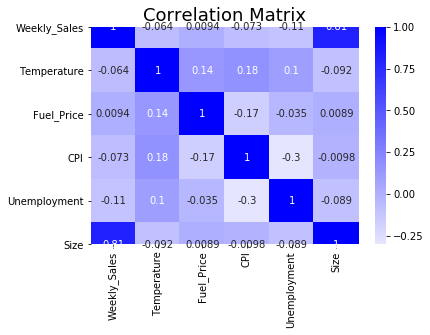

In [71]:
c = Quanti.corr()
cmap = sns.light_palette("Blue", 12, as_cmap=True)
sns.heatmap(c, annot=True, cmap = cmap)
plt.title('Correlation Matrix', fontsize=18)

> 5.1 Donner la valeur de corrélation entre `Weekly_Sales` et `Size`. 

0.81

> 5.2 Donner la valeur de corrélationentre `Weekly_Sales` et `Unemployment`. 

-0.11

> 5.3 Donner la valeur de corrélation entre `CPI` et `Fuel_prize`. 

-0.17

### 5.2 Dépendances entre variables quantitatives et qualitatives

Tracer les boxplots entre les ventes `Weekly_Sales` et le type `Type` de magasin.

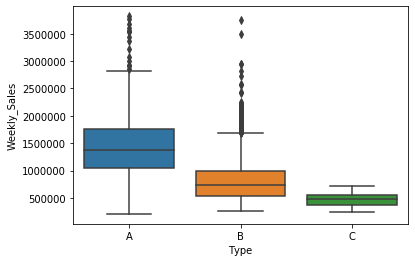

In [74]:
_=sns.boxplot(x=df2['Type'],y=df2['Weekly_Sales'])

> 5.4  Quel est, approximativement (et en millions), le 3e quartile pour les ventes des magasins de type B ? 1.5, 1, 0.75, 0.5 ?

1.0

> 5.5 Quelle est approximativement la médiane des ventes des magasins de type A ? 2, 1.5, 1, 0.75, 0.5 ?

1.5

> 5.6 Tracer les boxplots de la taille des magasins en fonction du type de ceux-ci. Quelle est approximativement la médiane de la taille des magasins pour le type B ? [175000, 150000, 120000, 100000] 

120000

> 5.7 Que penser de la relation entre taille et type ? [Dépendance importante, un peu de corrélation, quasi indépendante]

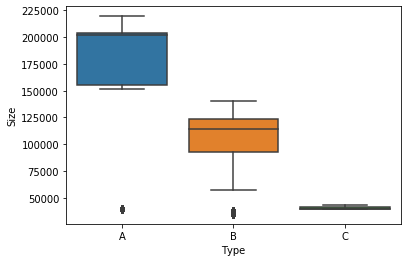

In [75]:
_=sns.boxplot(x=df2['Type'],y=df2['Size'])

Dépendance importante car dans les tailles sont homogènes et concentrées selon les types : par exemple pour le type A la taille est grande. Pour les types A et B nous avons aussi des outliers qui influencent le boxplot, s'ils étaient retirés nous aurions un boxplot comme en C, qui représente une forte corrélation (tous les magasins de type X ont globalement la même taille).

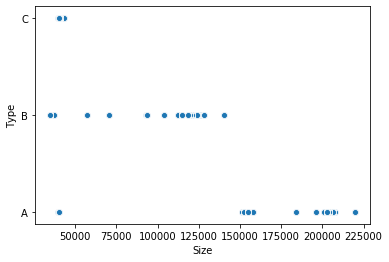

In [76]:
_ = sns.scatterplot(x='Size', y='Type', data=df2)

> 5.8 Tracer le boxplot de `Weekly_Sales` en fonction de `IsHoliday`. Que penser de la dépendance entre les ventes et `IsHoliday` [Forte dépendance, dépendance modérée, dépendance faible, pas de dépendance]

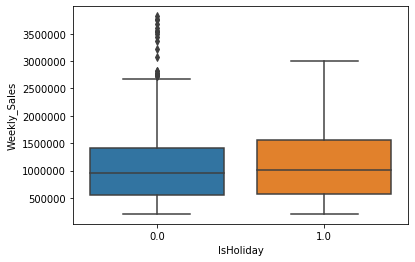

In [77]:
_=sns.boxplot(x=df2['IsHoliday'],y=df2['Weekly_Sales'])

Boxplot identiques, si nous retirions les outliers les allures seraient sans doute plus marquées.

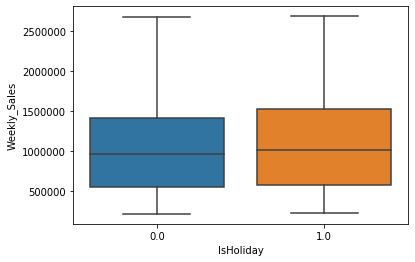

In [80]:
outlier=df2[df2['Weekly_Sales']<2700000]
_=sns.boxplot(x=outlier['IsHoliday'],y=outlier['Weekly_Sales'])

Ca ne change pas grand chose. On dirait qu'il y a une légère dépendance mais je pense que ça n'est pas concluant et négligeable.

### 5.9 - Analyse temporelle

> 5.9.1 Tracer l'évolution des ventes au cours du temps. Pour cela, on pourrait tracer magasin par magasin (en extrayant les données correspondantes). Une autre option serait de tracer l'évolution de la moyenne des ventes (sur l'ensemble des magasins), au cours du temps. C'est cette 2e solution qui est utilisée dans `sns.lineplot(...)` que l'on va mettre en oeuvre ici. 

> Utiliser `sns.lineplot`, avec les paramètres corrects, pour tracer l'évolution moyenne des ventes au cours du temps.


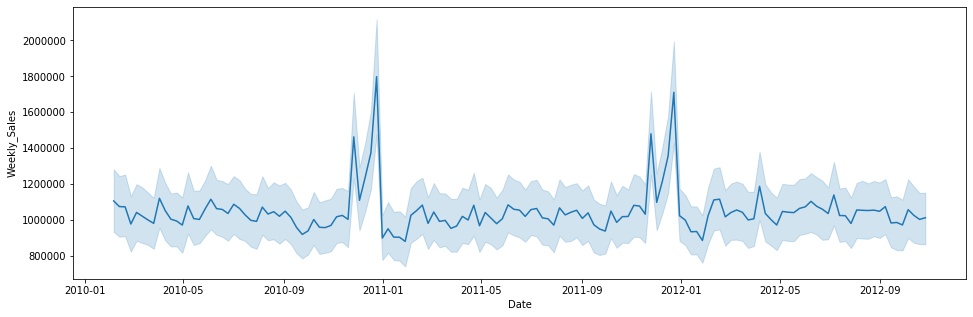

In [84]:
f, ax = plt.subplots(figsize=(16,5))
_=sns.lineplot(x=df2["Date"], y = df2["Weekly_Sales"],  ax=ax)

> 5.9.2 Que penser de l'évolution des ventes au cours de l'année ? [Baisse des ventes en été, Ventes constantes mis à part le week-end, Augmentation des ventes lors des fêtes de fin d'année, grosse ventes en janvier (soldes)]

Ete = entre mai et septembre (05-09)
Ventes globalement constantes à cette période.

1 mois = 4 week-ends. Pas de motif répétitif, pas de vente constante.

Le pic semble être atteint pour la période précédent janvier (fêtes de fin d'année)

## 6 - Encodage des variables


### 6.1 Normalisation
> Nous allons utiliser plus loin une régression linéaire afin d'essayer de prédire les ventes. Est-il utile de standardiser les données ? [oui, non]. Si c'est utile, refaites le, comme déjà effectué au moment de l'imputation. 

Non pas dans le cas d'une regression (pas d'influence).

**Variables qualitatives**

### 6.2 Encodage date

> Il nous faut encoder les variables qualitatives. Parmi celles-ci un cas particulier avec la date, que nous pouvons retravailler afin de faire apparaitre jours, mois et années. On le fait pour vous.

In [85]:
dfDate = pd.DataFrame()
dfDate['Year']=df2['Date'].dt.year
dfDate['Month']=df2['Date'].dt.month
dfDate['Week']=df2['Date'].dt.week
dfDate['Day']=df2['Date'].dt.day

In [125]:
dfDate.iloc[3333]["Day"]

10

### 6.4 Encodage OHE 

>Encoder les 3 autres variables qualitatives en one Hot. Vous pourrez utiliser soit le OneHotEncoder de sklearn, soit la méthode `pd.get_dummies` de pandas

In [86]:
df2['Store'] = df2['Store'].astype('category')   ## par précaution. Sinon il ne le reconnait pas forcément comme une catégorie

Store, IsHolidays et Type sont qualitatives

In [88]:
Quali = pd.get_dummies(df2[['Store', 'IsHoliday', 'Type']]) # one hot encoding

In [126]:
Quali.iloc[33]["Type_B"]

0.0

In [128]:
Quali.iloc[5194]["IsHoliday"]

0.0

In [129]:
Quali.iloc[402]["Store_2"]

0.0

## 7 - Régression linéaire

### 7.1 Définir une petite fonction qui :
- recevant un dataframe df, le nom de la variable à prédire, la taille de l'ensemble de test, retourne
    - le modèle calculé sur l'ensemble des données
    - le RSS, le RSE (sur l'ensemble d'apprentissage)
    - le R2 sur l'ensemble d'apprentissage, sur l'ensemble de test

In [155]:
def my_linear_regression(df, variable_a_predire, test_size=0.2, seed=SEED):
  
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score
    X = df.loc[:, df.columns != variable_a_predire]
    y = df[variable_a_predire]
    p = X.shape[1] #ordre du modèle
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=test_size,random_state=SEED)
    Ntrain = Xtrain.shape[0] # taille de l'ensemble d'apprentissage
    model = LinearRegression()
    model.fit(Xtrain, ytrain) # fit du modèle retourné sur l'ensemble des données
    y_pred_train = model.predict(Xtrain)
    y_pred_test = model.predict(Xtest)
    RSS = sum((ytrain-y_pred_train)**2)
    RSE = np.sqrt(sum((ytest-y_pred_test)**2)/(Ntrain-p-1))
    R2app = r2_score(ytrain,y_pred_train) # sur l'ensemble d'apprentissage
    R2test = r2_score(ytest,y_pred_test) # sur l'ensemble de test
    model.fit(X, y)

    return model, RSS, RSE, R2app, R2test

### 7.2 Vous cherchez donc à prédire `Weekly_Sales`. 

> Essayons cette prédiction uniquement à partir des données quantitatives (tableau `Quanti`), et avec une taille `test_size` de 0.2. 


In [156]:
model, RSS, RSE, R2app, R2test = my_linear_regression(Quanti, "Weekly_Sales")
print("R2 sur la base d'apprentissage", R2app)
print("R2 sur la base de test", R2test)

R2 sur la base d'apprentissage 0.6682000047858137
R2 sur la base de test 0.6560663783128916


> Donner la valeur du R2 sur la base d'apprentissage, sur la base de test

### 7.3 Construire maintenant un nouveau tableau, `data`, 
> qui regroupe ces variables quantitatives, le tableau `dfDate`  issu de la date, et les variables qualitatives issues de l'encodage OHE `Quali`. Vous utiliserez la méthode `pd.concat`

In [159]:
data = pd.concat([df2[quanti], dfDate, Quali], axis = 1)
data.head()

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size,Year,Month,Week,Day,...,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Type_A,Type_B,Type_C
0,1643690.90,42.31,2.572,211.096358,8.106,151315.0,2010,2,5,5,...,0,0,0,0,0,0,0,1,0,0
1,1641957.44,38.51,2.548,211.242170,8.106,151315.0,2010,2,6,12,...,0,0,0,0,0,0,0,1,0,0
2,1611968.17,39.93,2.514,211.289143,8.106,151315.0,2010,2,7,19,...,0,0,0,0,0,0,0,1,0,0
3,1409727.59,46.63,2.561,211.319643,8.106,151315.0,2010,2,8,26,...,0,0,0,0,0,0,0,1,0,0
4,1554806.68,46.50,2.625,211.350143,8.106,151315.0,2010,3,9,5,...,0,0,0,0,0,0,0,1,0,0


Combien ce nouveau tableau contient-il de colonnes ?

In [160]:
data.shape[1]

59

### 7.4 Effectuer la régression linéaire 
> avec ces dernières données. Donner la valeur du R2 sur la base d'apprentissage, sur la base de test

In [161]:
model, RSS, RSE, R2app, R2test = my_linear_regression(data, "Weekly_Sales")
print("R2 sur la base d'apprentissage", R2app)
print("R2 sur la base de test", R2test)

R2 sur la base d'apprentissage 0.9293156343454861
R2 sur la base de test 0.9204839526122123


## 8 - Feature engineering final

Comme on l'a vu, il semble que les fêtes de fin d'année aient une influence sensible sur les ventes. Le graphique suivant, tracé cette fois en fonction des semaines, le montre à nouveau. 

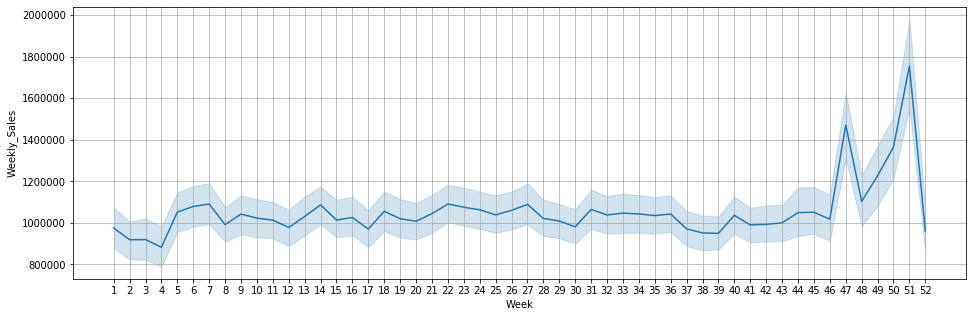

In [134]:
f, ax = plt.subplots(figsize=(16,5))
sns.lineplot(x='Week', y='Weekly_Sales',  data=data, ax=ax)
_ = ax.set_xticks(range(1,53))
plt.grid()

> ### 8.1 Définir une variable 'End_of_year_holidays' 
> qui encode cette période. L'optimum étant sans doute que cette variable vaille 1 pour les semaines 47, 49, 50 et 51 et 0 sinon.


In [162]:
data['End_of_year_holidays'] = data.apply(lambda row: True if row['Week'] in [47, 49, 50, 51] else False, axis=1)
data['End_of_year_holidays'] = data['End_of_year_holidays'].replace({True:1, False:0}) 

In [163]:
data.iloc[1559]['End_of_year_holidays']

0.0

> ### 8.2 Tester votre régression linéaire 
> A l'aide de ce dernier modèle, donner la valeur du R2 sur la base d'apprentissage et sur la base de test.

In [164]:
model, RSS, RSE, R2app, R2test = my_linear_regression(data, "Weekly_Sales")
print("R2 sur la base d'apprentissage", R2app)
print("R2 sur la base de test", R2test)

R2 sur la base d'apprentissage 0.9520986080355924
R2 sur la base de test 0.9467579634714519
